In [1]:
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

In [2]:
# ! pip install langchain_community
# ! pip install -U langgraph

### One Agent

In [3]:
from langchain_openai import ChatOpenAI

In [4]:
llm = ChatOpenAI(model="llama3", api_key = 'ollama', base_url='http://localhost:11434/v1/')
prompt = ChatPromptTemplate.from_template("Tell me a short joke about {topic}")
chain = prompt | llm | StrOutputParser()
chain.invoke({'topic': "Machine Learning"})

"Here's one:\n\nWhy did the machine learning model go to therapy?\n\nBecause it was struggling to generalize its emotions and had a lot of bias towards being anxious!"

In [5]:
CH_HOST = 'http://localhost:8123' # default address 
import requests

def get_clickhouse_data(query, host = CH_HOST, connection_timeout = 1500):
  r = requests.post(host, params = {'query': query}, 
    timeout = connection_timeout)
  if r.status_code == 200:
      return r.text
  else: 
      return 'Database returned the following error:\n' + r.text

In [6]:
from langchain_core.tools import tool
from pydantic.v1 import BaseModel, Field
from typing import Optional

class SQLQuery(BaseModel):
    query: str = Field(description="SQL query to execute")

@tool(args_schema = SQLQuery)
def execute_sql(query: str) -> str:
    """Returns the result of SQL query execution"""
    return get_clickhouse_data(query)

In [138]:
print(f'''
name: {execute_sql.name}
description: {execute_sql.description}
arguments: {execute_sql.args}
''')


name: execute_sql
description: Returns the result of SQL query execution
arguments: {'query': {'title': 'Query', 'description': 'SQL query to execute', 'type': 'string'}}



In [7]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage

In [49]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [147]:
class SQLAgent:
    def __init__(self, model, tools, system_prompt=""):
        self.system_prompt = system_prompt
        
        # initialising graph with a state 
        graph = StateGraph(AgentState)
        
        # adding nodes 
        graph.add_node("llm", self.call_llm)
        graph.add_node("function", self.execute_function)
        graph.add_conditional_edges(
            "llm",
            self.exists_function_calling,
            {True: "function", False: END}
            )
        graph.add_edge("function", "llm")
        
        # setting starting point
        graph.set_entry_point("llm")
        
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_function_calling(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_llm(self, state: AgentState):
        messages = state['messages']
        if self.system_prompt:
            messages = [SystemMessage(content=self.system_prompt)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def execute_function(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [148]:
# ! brew install graphviz

In [149]:
# ! python3 -m pip install -U --no-cache-dir  \
#                 --config-settings="--global-option=build_ext" \
#                 --config-settings="--global-option=-I$(brew --prefix graphviz)/include/" \
#                 --config-settings="--global-option=-L$(brew --prefix graphviz)/lib/" \
#                 pygraphviz


# https://github.com/pygraphviz/pygraphviz/issues/398

In [15]:
import json
import os
with open('../../config.json') as f:
    config = json.loads(f.read())

os.environ["OPENAI_MODEL_NAME"]='gpt-4o-mini'  
os.environ["OPENAI_API_KEY"] = config['OPENAI_API_KEY']
os.environ["TAVILY_API_KEY"] = config["TAVILY_API_KEY"]

In [158]:
prompt = '''You are a senior expert in SQL and data analysis. 
So, you can help the team to gather needed data to power their decisions. 
You are very accurate and take into account all the nuances in data.
Your goal is to provide the detailed documentation for the table in database 
that will help users. Please, keep your answers concise and straight to the point.'''

# model = ChatOpenAI(model="llama3", api_key = 'ollama', base_url='http://localhost:11434/v1/')
model = ChatOpenAI(model="gpt-4o-mini")
doc_agent = SQLAgent(model, [execute_sql], system_prompt=prompt)

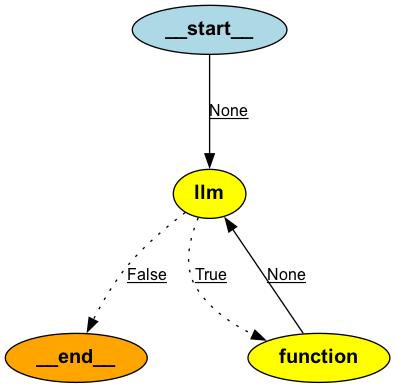

In [159]:
from IPython.display import Image

Image(doc_agent.graph.get_graph().draw_png())

In [160]:
messages = [HumanMessage(content="What info do we have in ecommerce_db.users table?")]
result = doc_agent.graph.invoke({"messages": messages})

Calling: {'name': 'execute_sql', 'args': {'query': 'DESCRIBE ecommerce_db.users;'}, 'id': 'call_qZbDU9Coa2tMjUARcX36h0ax', 'type': 'tool_call'}
Back to the model!


In [163]:
print(result['messages'])

[HumanMessage(content='What info do we have in ecommerce_db.users table?'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qZbDU9Coa2tMjUARcX36h0ax', 'function': {'arguments': '{"query":"DESCRIBE ecommerce_db.users;"}', 'name': 'execute_sql'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 136, 'total_tokens': 156}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_ba606877f9', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ce787309-9a20-4aca-afbe-e8e192eccb82-0', tool_calls=[{'name': 'execute_sql', 'args': {'query': 'DESCRIBE ecommerce_db.users;'}, 'id': 'call_qZbDU9Coa2tMjUARcX36h0ax', 'type': 'tool_call'}], usage_metadata={'input_tokens': 136, 'output_tokens': 20, 'total_tokens': 156}), ToolMessage(content='user_id\tUInt64\t\t\t\t\t\ncountry\tString\t\t\t\t\t\nis_active\tUInt8\t\t\t\t\t\nage\tUInt64\t\t\t\t\t\n', name='execute_sql', tool_call_id='call_qZbDU9Coa2tMjUARcX36h0ax'), AIM

In [ ]:
[
    HumanMessage(content='What info do we have in ecommerce_db.users table?'), 
    AIMessage(content='', tool_calls=[{'name': 'execute_sql', 'args': {'query': 'DESCRIBE ecommerce_db.users;'}, 'id': 'call_qZbDU9Coa2tMjUARcX36h0ax', 'type': 'tool_call'}]), 
    ToolMessage(content='user_id\tUInt64\t\t\t\t\t\ncountry\tString\t\t\t\t\t\nis_active\tUInt8\t\t\t\t\t\nage\tUInt64\t\t\t\t\t\n', name='execute_sql', tool_call_id='call_qZbDU9Coa2tMjUARcX36h0ax'), 
    AIMessage(content='The `ecommerce_db.users` table contains the following columns: <...>')
]

In [164]:
print(result['messages'][-1].content)

The `ecommerce_db.users` table contains the following columns:

1. **user_id**: `UInt64` - A unique identifier for each user.
2. **country**: `String` - The country where the user is located.
3. **is_active**: `UInt8` - Indicates whether the user is active (1) or inactive (0).
4. **age**: `UInt64` - The age of the user.


In [65]:
# ! pip install langchainhub

In [119]:
model = ChatOpenAI(model="llama3", api_key = 'ollama', base_url='http://localhost:11434/v1/')
model = ChatOpenAI(model="gpt-4o-mini")

In [165]:
# from langchain import hub
# prompt = hub.pull('hwchase17/react')
# prompt.pretty_print()

In [121]:
from langgraph.prebuilt import create_react_agent

In [171]:
prebuilt_doc_agent = create_react_agent(model, [execute_sql])

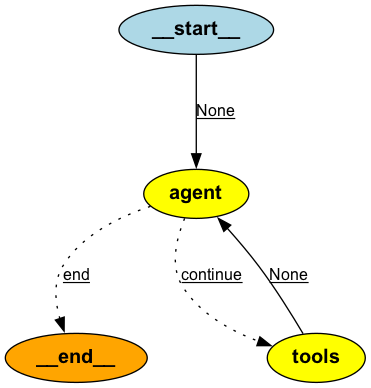

In [172]:
Image(prebuilt_doc_agent.get_graph().draw_png())

In [125]:
inputs = {"messages": [("user", "What columns are in ecommerce_db.users?")]}

result = agent.invoke(inputs)

In [126]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

# https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/#usage

In [128]:
print_stream(agent.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What columns are in ecommerce_db.users?
================================== Ai Message ==================================
Tool Calls:
  get_table_structure (call_fIFrtMNZzpZFT2yfbUHdfhY1)
 Call ID: call_fIFrtMNZzpZFT2yfbUHdfhY1
  Args:
    table: ecommerce_db.users
================================= Tool Message =================================
Name: get_table_structure

name	type	default_type	default_expression	comment	codec_expression	ttl_expression
user_id	UInt64					
country	String					
is_active	UInt8					
age	UInt64					

================================== Ai Message ==================================

The columns in the `ecommerce_db.users` table are as follows:

1. **user_id**: Type - `UInt64`
2. **country**: Type - `String`
3. **is_active**: Type - `UInt8`
4. **age**: Type - `UInt64`


### Persistence and streaming

In [176]:
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver.from_conn_string(":memory:")

In [179]:
prebuilt_doc_agent = create_react_agent(model, [execute_sql], checkpointer = memory)

In [181]:
thread = {"configurable": {"thread_id": "18"}}
messages = [HumanMessage(content="What info do we have in ecommerce_db.users table?")]

for event in prebuilt_doc_agent.stream({"messages": messages}, thread):
    for v in event.values():
        v['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_jDzlj3JaVOqf6EH50t7qH6nz)
 Call ID: call_jDzlj3JaVOqf6EH50t7qH6nz
  Args:
    query: SELECT * FROM ecommerce_db.users LIMIT 5;
================================= Tool Message =================================
Name: execute_sql

1000001	United Kingdom	0	70
1000002	France	1	87
1000003	France	1	88
1000004	Germany	1	25
1000005	Germany	1	48

================================== Ai Message ==================================

The `ecommerce_db.users` table contains the following information for each user:

1. User ID
2. Country
3. Some binary or categorical value (possibly indicating active status or membership)
4. A numerical value (possibly indicating age, score, or another metric)

Here are the details for the first five users:

| User ID | Country        | Status | Metric |
|---------|----------------|--------|--------|
| 1000001 | United Kingdom  | 0      | 70     |
| 1000002 | F

In [182]:
followup_messages = [HumanMessage(content="I would like to know the column names and types. Maybe you could look it up in database using describe.")]

for event in prebuilt_doc_agent.stream({"messages": followup_messages}, thread):
    for v in event.values():
        v['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_sQKRWtG6aEB38rtOpZszxTVs)
 Call ID: call_sQKRWtG6aEB38rtOpZszxTVs
  Args:
    query: DESCRIBE ecommerce_db.users;
================================= Tool Message =================================
Name: execute_sql

user_id	UInt64					
country	String					
is_active	UInt8					
age	UInt64					

================================== Ai Message ==================================

The `ecommerce_db.users` table has the following columns along with their data types:

| Column Name | Data Type |
|-------------|-----------|
| user_id     | UInt64    |
| country     | String    |
| is_active   | UInt8     |
| age         | UInt64    |

If you need further information or assistance, feel free to ask!


In [183]:
new_thread = {"configurable": {"thread_id": "42"}}
followup_messages = [HumanMessage(content="I would like to know the column names and types. Maybe you could look it up in database using describe.")]

for event in prebuilt_doc_agent.stream({"messages": followup_messages}, new_thread):
    for v in event.values():
        v['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_LrmsOGzzusaLEZLP9hGTBGgo)
 Call ID: call_LrmsOGzzusaLEZLP9hGTBGgo
  Args:
    query: DESCRIBE your_table_name;
================================= Tool Message =================================
Name: execute_sql

Database returned the following error:
Code: 60. DB::Exception: Table default.your_table_name does not exist. (UNKNOWN_TABLE) (version 23.12.1.414 (official build))

================================== Ai Message ==================================

It seems that the table `your_table_name` does not exist in the database. Could you please provide the actual name of the table you want to describe?


## Multi agent set up

In [8]:
# import importlib
# importlib.reload(langgraph)

In [9]:
from langgraph.prebuilt import create_react_agent

In [79]:
class MultiAgentState(TypedDict):
    question: str
    question_type: str
    answer: str
    feedback: str

In [38]:
question_category_prompt = '''You are a senior specialist of analytical support. Your task is to classify the incoming questions. 
Depending on your answer, question will be routed to the right team, so your task is crucial for our team. 
There are 3 possible question types: 
- DATABASE - questions related to our database (tables or fields)
- LANGCHAIN- questions related to LangGraph or LangChain libraries
- GENERAL - general questions
Return in the output only one word (DATABASE, LANGCHAIN or  GENERAL).
'''

def router_node(state: MultiAgentState):
    print('Router node started execution')
    messages = [
        SystemMessage(content=question_category_prompt), 
        HumanMessage(content=state['question'])
    ]
    model = ChatOpenAI(model="gpt-4o-mini")
    response = model.invoke(messages)
    print('Question type: %s' % response.content)
    return {"question_type": response.content}

In [61]:
sql_expert_system_prompt = '''
You are an expert in SQL, so you can help the team 
to gather needed data to power their decisions. 
You are very accurate and take into account all the nuances in data. 
You use SQL to get the data before answering the question.
'''

def sql_expert_node(state: MultiAgentState):
    model = ChatOpenAI(model="gpt-4o-mini")
    sql_agent = create_react_agent(model, [execute_sql],
        state_modifier = sql_expert_system_prompt)
    messages = [HumanMessage(content=state['question'])]
    result = sql_agent.invoke({"messages": messages})
    return {'answer': result['messages'][-1].content}

In [62]:
from langchain_community.tools.tavily_search import TavilySearchResults
# https://python.langchain.com/v0.1/docs/integrations/tools/tavily_search/
tavily_tool = TavilySearchResults(max_results=5)

search_expert_system_prompt = '''
You are an expert in LangChain and other technologies. 
Your goal is to answer questions based on results provided by search.
You don't add anything yourself and provide only information baked by other sources. 
'''

def search_expert_node(state: MultiAgentState):
    model = ChatOpenAI(model="gpt-4o-mini")
    sql_agent = create_react_agent(model, [tavily_tool],
        state_modifier = search_expert_system_prompt)
    messages = [HumanMessage(content=state['question'])]
    result = sql_agent.invoke({"messages": messages})
    return {'answer': result['messages'][-1].content}

In [63]:
general_prompt = '''You're a friendly assistant and your goal is to answer general questions.
Please, don't provide any unchecked information and just tell that you don't know if you don't have enough info.
'''

def general_assistant_node(state: MultiAgentState):
    messages = [
        SystemMessage(content=general_prompt), 
        HumanMessage(content=state['question'])
    ]
    model = ChatOpenAI(model="gpt-4o-mini")
    response = model.invoke(messages)
    return {"answer": response.content}

In [187]:
def human_feedback_node(state: MultiAgentState):
    pass

editor_prompt = '''You're an editor and your goal is to provide the final answer to the customer, taking into account the feedback. 
You don't add any information on your own. You use friendly and professional tone. 
In the output please provide the final answer to the customer without additional comments.
Here's all the information you need.


Question from customer: 
----
{question}
----
Draft answer:
----
{answer}
----
Feedback: 
----
{feedback}
----
'''

def editor_node(state: MultiAgentState):
    print(state)
    messages = [
        SystemMessage(content=editor_prompt.format(question = state['question'], answer = state['answer'], feedback = state['feedback']))
    ]
    model = ChatOpenAI(model="gpt-4o-mini")
    response = model.invoke(messages)
    return {"answer": response.content}

In [188]:
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver.from_conn_string(":memory:")

In [189]:
def route_question(state: MultiAgentState):
    print('route function execution')
    print(state)
    return state['question_type']

In [190]:
builder = StateGraph(MultiAgentState)
builder.add_node("router", router_node)
builder.add_node('database_expert', sql_expert_node)
builder.add_node('langchain_expert', search_expert_node)
builder.add_node('general_assistant', general_assistant_node)
builder.add_node('human', human_feedback_node)
builder.add_node('editor', editor_node)

builder.add_conditional_edges(
    "router", 
    route_question,
    {'DATABASE': 'database_expert', 'LANGCHAIN': 'langchain_expert', 'GENERAL': 'general_assistant'}
)

builder.set_entry_point("router")

builder.add_edge('database_expert', 'human')
builder.add_edge('langchain_expert', 'human')
builder.add_edge('general_assistant', 'human')
builder.add_edge('human', 'editor')
builder.add_edge('editor', END)

In [191]:
graph = builder.compile(checkpointer=memory, interrupt_before = ['human'])

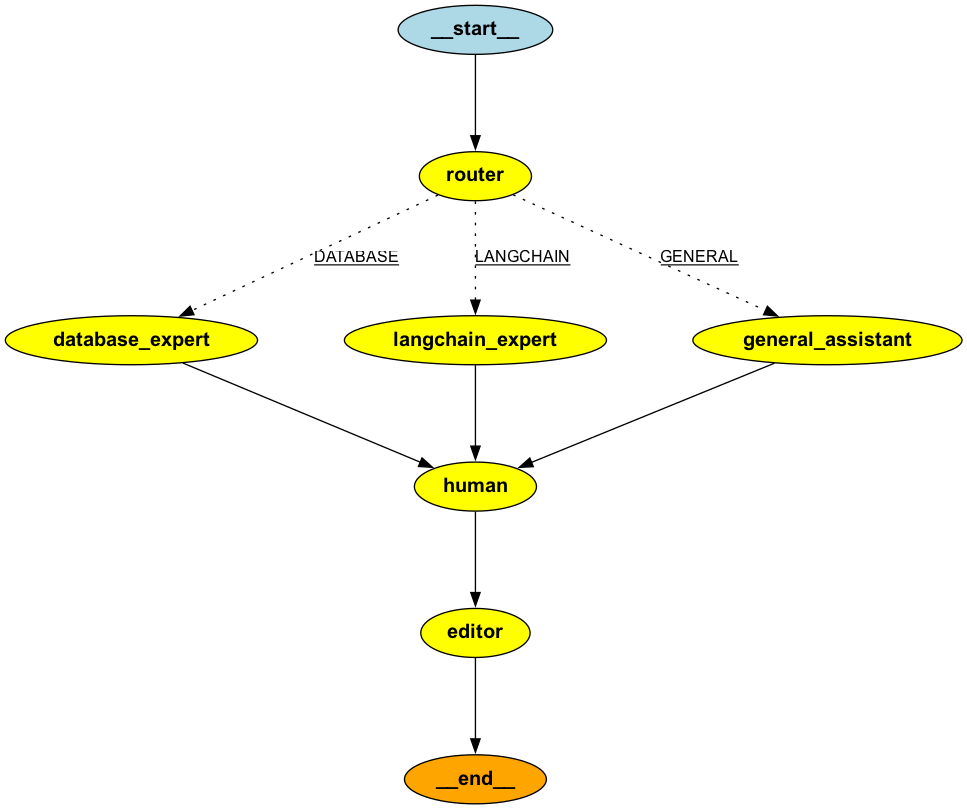

In [192]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [211]:
thread = {"configurable": {"thread_id": "42"}}
results = []

for event in graph.stream({
    'question': "What are the types of fields in ecommerce_db.users table?",
}, thread):
    print(event)
    results.append(event)

Router node started execution
Question type: DATABASE
route function execution
{'question_type': 'DATABASE', 'question': 'What are the types of fields in ecommerce_db.users table?', 'answer': 'Hello! \n\nThe `ecommerce_db.users` table has the following fields:\n\n1. **user_id**: UInt64\n2. **country**: String\n3. **is_active**: UInt8\n4. **age**: UInt64\n\nHave a nice day!', 'feedback': 'It looks wonderful. Could you only make it a bit friendlier adding hello and have a nice day please?'}
{'router': {'question_type': 'DATABASE'}}
{'database_expert': {'answer': 'The `ecommerce_db.users` table has the following fields:\n\n1. **user_id**: UInt64\n2. **country**: String\n3. **is_active**: UInt8\n4. **age**: UInt64'}}


In [221]:
results[1]['database_expert']['answer']

'The `ecommerce_db.users` table has the following fields:\n\n1. **user_id**: UInt64\n2. **country**: String\n3. **is_active**: UInt8\n4. **age**: UInt64'

In [212]:
user_input = input("Do I need to change anything in the answer?")

Do I need to change anything in the answer? It looks wonderful. Could you only make it a bit friendlier adding hello and have a nice day please?


In [214]:
graph.update_state(thread, {"feedback": user_input}, as_node="human")

{'configurable': {'thread_id': '42',
  'thread_ts': '1ef54885-527d-62a6-800b-181220993b35'}}

In [215]:
print(graph.get_state(thread).values)

{'question': 'What are the types of fields in ecommerce_db.users table?', 'question_type': 'DATABASE', 'answer': 'The `ecommerce_db.users` table has the following fields:\n\n1. **user_id**: UInt64\n2. **country**: String\n3. **is_active**: UInt8\n4. **age**: UInt64', 'feedback': 'It looks wonderful. Could you only make it a bit friendlier adding hello and have a nice day please?'}


In [216]:
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

{'question': 'What are the types of fields in ecommerce_db.users table?', 'question_type': 'DATABASE', 'answer': 'The `ecommerce_db.users` table has the following fields:\n\n1. **user_id**: UInt64\n2. **country**: String\n3. **is_active**: UInt8\n4. **age**: UInt64', 'feedback': 'It looks wonderful. Could you only make it a bit friendlier adding hello and have a nice day please?'}
{'question': 'What are the types of fields in ecommerce_db.users table?', 'question_type': 'DATABASE', 'answer': 'Hello! The `ecommerce_db.users` table has the following fields:\n\n1. **user_id**: UInt64\n2. **country**: String\n3. **is_active**: UInt8\n4. **age**: UInt64\n\nHave a nice day!', 'feedback': 'It looks wonderful. Could you only make it a bit friendlier adding hello and have a nice day please?'}


In [217]:
print(event['answer'])

Hello! The `ecommerce_db.users` table has the following fields:

1. **user_id**: UInt64
2. **country**: String
3. **is_active**: UInt8
4. **age**: UInt64

Have a nice day!


### Using Human tool

In [218]:
from langchain_community.tools import HumanInputRun

human_tool = HumanInputRun()

In [222]:
state = {'question': 'What are the types of fields in ecommerce_db.users table?', 
         'answer': 'The `ecommerce_db.users` table has the following fields:\n\n1. **user_id**: UInt64\n2. **country**: String\n3. **is_active**: UInt8\n4. **age**: UInt64'
        }

In [229]:
editor_agent_prompt = '''You're an editor and your goal is to provide the final answer to the customer, taking into the initial question.
If you need any clarifications or need feedback, please, use human. Always reach out to human to get the feedback before final answer.
You don't add any information on your own. You use friendly and professional tone. 
In the output please provide the final answer to the customer without additional comments.
Here's all the information you need.

Question from customer: 
----
{question}
----
Draft answer:
----
{answer}
----
'''

model = ChatOpenAI(model="gpt-4o-mini")
editor_agent = create_react_agent(model, [human_tool])
messages = [SystemMessage(content=editor_agent_prompt.format(question = state['question'], answer = state['answer']))]
editor_result = editor_agent.invoke({"messages": messages})



Is the draft answer complete and accurate for the customer's question about the types of fields in the ecommerce_db.users table?


 Yes, but could you please make it friendlier.


In [236]:
print(editor_result['messages'][-1].content)

The `ecommerce_db.users` table has the following fields:

1. **user_id**: UInt64
2. **country**: String
3. **is_active**: UInt8
4. **age**: UInt64

If you have any more questions, feel free to ask!


In [237]:
def editor_agent_node(state: MultiAgentState):
    model = ChatOpenAI(model="gpt-4o-mini")
    editor_agent = create_react_agent(model, [human_tool])
    messages = [SystemMessage(content=editor_agent_prompt.format(question = state['question'], answer = state['answer']))]
    result = editor_agent.invoke({"messages": messages})
    return {'answer': result['messages'][-1].content}

In [238]:
builder = StateGraph(MultiAgentState)
builder.add_node("router", router_node)
builder.add_node('database_expert', sql_expert_node)
builder.add_node('langchain_expert', search_expert_node)
builder.add_node('general_assistant', general_assistant_node)
builder.add_node('editor', editor_agent_node)

builder.add_conditional_edges(
    "router", 
    route_question,
    {'DATABASE': 'database_expert', 'LANGCHAIN': 'langchain_expert', 'GENERAL': 'general_assistant'}
)

builder.set_entry_point("router")

builder.add_edge('database_expert', 'editor')
builder.add_edge('langchain_expert', 'editor')
builder.add_edge('general_assistant', 'editor')
builder.add_edge('editor', END)

In [240]:
graph = builder.compile(checkpointer=memory)

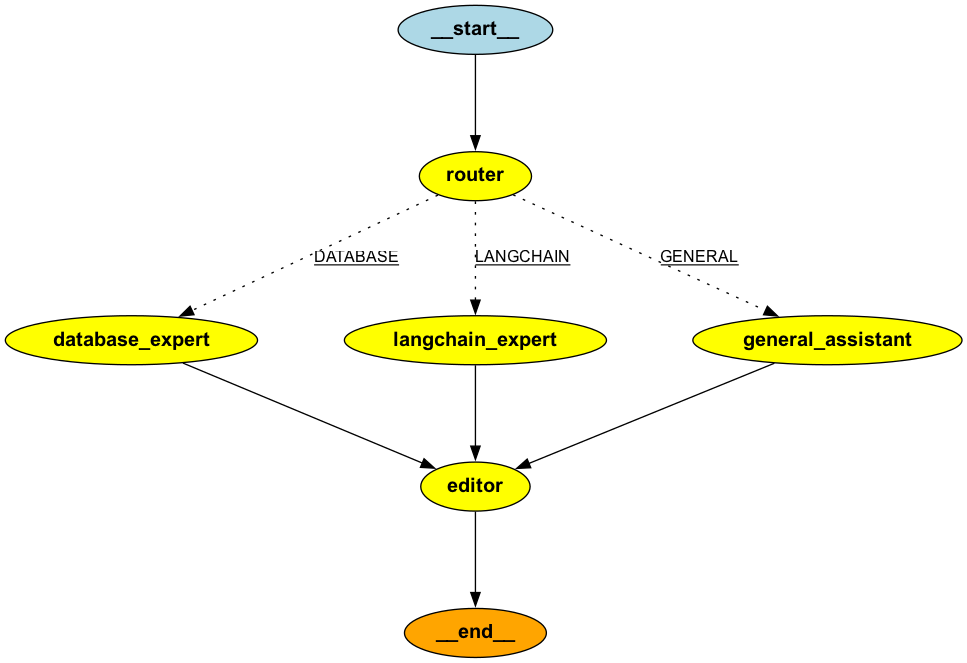

In [241]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [242]:
thread = {"configurable": {"thread_id": "42"}}
results = []

for event in graph.stream({
    'question': "What are the types of fields in ecommerce_db.users table?",
}, thread):
    print(event)
    results.append(event)

Router node started execution
Question type: DATABASE
route function execution
{'question_type': 'DATABASE', 'question': 'What are the types of fields in ecommerce_db.users table?', 'answer': 'Hello! The `ecommerce_db.users` table has the following fields:\n\n1. **user_id**: UInt64\n2. **country**: String\n3. **is_active**: UInt8\n4. **age**: UInt64\n\nHave a nice day!', 'feedback': 'It looks wonderful. Could you only make it a bit friendlier adding hello and have a nice day please?'}
{'router': {'question_type': 'DATABASE'}}
{'database_expert': {'answer': 'The `ecommerce_db.users` table has the following fields:\n\n1. **user_id**: UInt64\n2. **country**: String\n3. **is_active**: UInt8\n4. **age**: UInt64'}}


Is the draft answer complete and accurate regarding the fields in the ecommerce_db.users table?


 Yes, but could you please add some polite words like "hello" and "have a nice day"


{'editor': {'answer': 'The `ecommerce_db.users` table has the following fields:\n\n1. **user_id**: UInt64\n2. **country**: String\n3. **is_active**: UInt8\n4. **age**: UInt64\n\nHello! I hope this information helps you. Have a nice day!'}}
